In [1]:
import sys
sys.path.append('../')

from activation import *
from loss import *
from linear import * 
from encapsulage import *
from utils import *

import matplotlib.pyplot as plt
import random
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
import seaborn as sns
from sklearn.metrics import confusion_matrix

def onehot(x): 
    out = [0] * 10
    out[x] = 1
    return out

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
#vectoriser l'image et normaliser
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# selectionner un sous ensemble
X_train = X_train[:2000]
y_train = y_train[:2000]
X_test = X_test[:1000]
y_test = y_test[:1000]

# Transformer les labels en one-hot encoding
y_train = np.asarray([onehot(y) for y in y_train])



batchsize = 450
epoch = 2000
gradient_step = 1e-4

input_dim = X_train.shape[1]
hidden_dim = 100
hidden_dim2 = 10
output_dim = 784


tanh = TanH()

# encodeur 
layer1 = Linear(input_dim, hidden_dim)
layer2 = tanh
layer3 = Linear(hidden_dim, hidden_dim2)
layer4 = tanh
encodeur = [layer1, layer2, layer3, layer4]

# décodeur 
layer5 = Linear(hidden_dim2, hidden_dim)
layer5._parameters = layer3._parameters.T
layer6 = tanh
layer7 = Linear(hidden_dim, output_dim)
layer7._parameters = layer1._parameters.T
layer8 = Sigmoid()
decodeur = [layer5, layer6, layer7, layer8]

net = Sequentiel(encodeur + decodeur)

# perte
loss = MSELoss()


# Entraînement
optim = Optim(net, loss, gradient_step)
lloss = optim.SGD(X_train, X_train, batchsize, epoch)



100%|██████████| 2000/2000 [07:08<00:00,  4.66it/s]


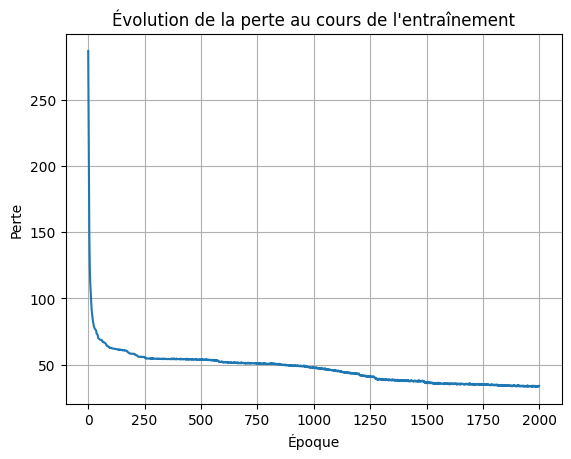

In [3]:
# Affichage de la perte
plot_loss(lloss)

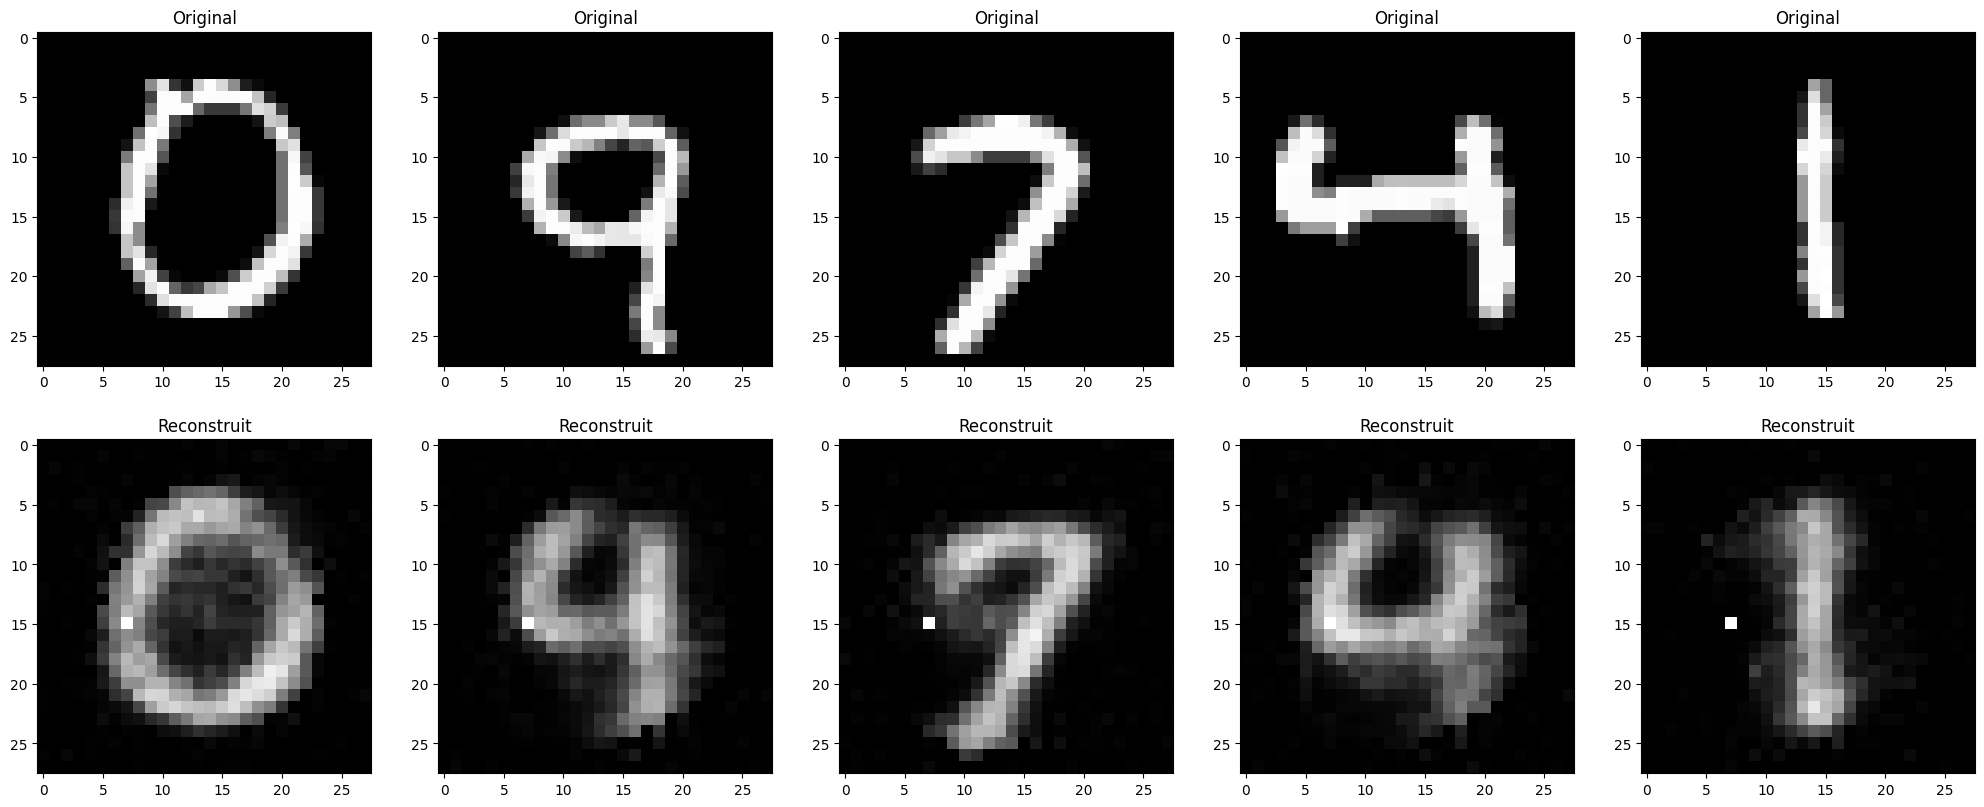

In [4]:
def show_image(data,n):
    plt.imshow(data.reshape((n,n)),interpolation="nearest",cmap="gray")
   
def show_reconstruction(X_test,net,n=28,n_comp=8):
    
    nb_photo=5
    ids = np.random.choice(np.arange(X_test.shape[0]), nb_photo, replace=False)
    
    plt.figure(figsize=(5*nb_photo,15))
    j = 1
    for i in ids:
        plt.subplot(3,nb_photo,j)
        plt.title("Original")
        show_image(X_test[i],n)

        plt.subplot(3,nb_photo,j+nb_photo)
        plt.title("Reconstruit")
        show_image(net.predict(np.asarray([X_test[i]]),'enc'),n)
        j+=1
         
show_reconstruction(X_test,optim.net,n_comp=4)
plt.show()
plt.close()

In [5]:

def calculate_accuracy(X_test, net, threshold=0.05):
    correct_reconstructions = 0
    total_images = X_test.shape[0]
    for i in range(total_images):
        original = X_test[i]
        reconstructed = net.predict(np.asarray([X_test[i]]), 'enc')
        # calcule de la MSE entre l'image originale et reconstruite
        mse = np.mean((original - reconstructed) ** 2)
        # correcte si la MSE est inférieure au seuil
        if mse < threshold:
            correct_reconstructions += 1

    accuracy = correct_reconstructions / total_images
    return accuracy


accuracy = calculate_accuracy(X_test, optim.net)
print(f"Accuracy de la reconstruction: {accuracy * 100:.2f}%")

Accuracy de la reconstruction: 63.20%
